## Task 1

### Required libraries


In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import math


### Load images

In [2]:
# Load object and scene images
# Comment out the examples you don't want to run
image_dir = "ex1-images"

# example 1: wally and wally_scene
# object_img = cv.imread(os.path.join(image_dir, 'wally.png'))
# scene_img = cv.imread(os.path.join(image_dir, 'find_wally.jpeg'))
# example 2: box and box_scene
# object_img = cv.imread(os.path.join(image_dir, 'match_box01a_1.png'))
# scene_img = cv.imread(os.path.join(image_dir, 'match_box01a_2.png'))
# example 3: elephant and scene
object_img = cv.imread(os.path.join(image_dir, 'match_scene01_2.png'))
scene_img = cv.imread(os.path.join(image_dir, 'match_scene01_3.png'))
# example 4: box2 and scene
# object_img = cv.imread(os.path.join(image_dir, 'match_scene01_1.png'))
# scene_img = cv.imread(os.path.join(image_dir, 'match_scene01_3.png'))


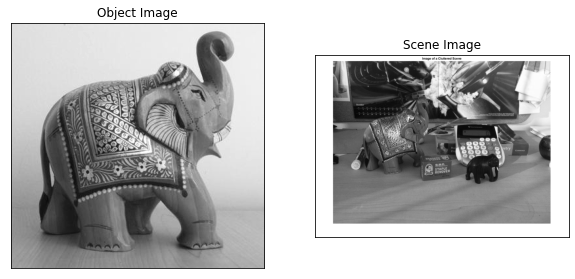

In [3]:
# Convert images to grayscale
object_gray = cv.cvtColor(object_img, cv.COLOR_BGR2GRAY)
scene_gray = cv.cvtColor(scene_img, cv.COLOR_BGR2GRAY)

# Display
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(object_gray, cmap='gray')
plt.title('Object Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(scene_gray, cmap='gray')
plt.title('Scene Image'), plt.xticks([]), plt.yticks([])
plt.show()

### Key Points and Descriptors detection

- SIFT
- ORB
- BRISK
- KAZE

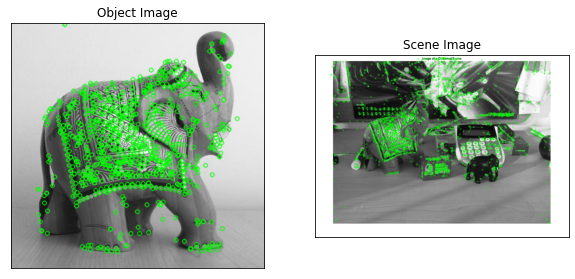

In [4]:
# Feature detector
# SIFT-0 (Scale Invariant Feature Transform)
# ORB-1 (Oriented FAST and Rotated BRIEF)
# BRISK-2 (Binary Robust Invariant Scalable Keypoints)
# KAZE-3 (Accelerated-SIFT)
option = 0
match option:
    case 0:
        fd = cv.SIFT_create()
    case 1:
        fd = cv.ORB_create()
    case 2:
        fd = cv.BRISK_create()
    case 3:
        fd = cv.KAZE_create()
    case _:
        fd = cv.SIFT_create()

# Find the keypoints and descriptors
kp1, des1 = fd.detectAndCompute(object_gray, None)
kp2, des2 = fd.detectAndCompute(scene_gray, None)

# Display
img1 = cv.drawKeypoints(object_gray, kp1, None, color=(0, 255, 0), flags=0)
img2 = cv.drawKeypoints(scene_gray, kp2, None, color=(0, 255, 0), flags=0)
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img1, cmap='gray')
plt.title('Object Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img2, cmap='gray')
plt.title('Scene Image'), plt.xticks([]), plt.yticks([])
plt.show()



### Matching

In [5]:
# Match descriptors
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

In [6]:
# Match descriptors
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

##### Lowe Ratio Test

In [7]:
# Apply ratio test
good = []
ratio = 0.7
for match_pair in matches:
    if len(match_pair) == 2:
        m, n = match_pair
        if m.distance < ratio * n.distance:
            good.append(m)


#### Find Homography

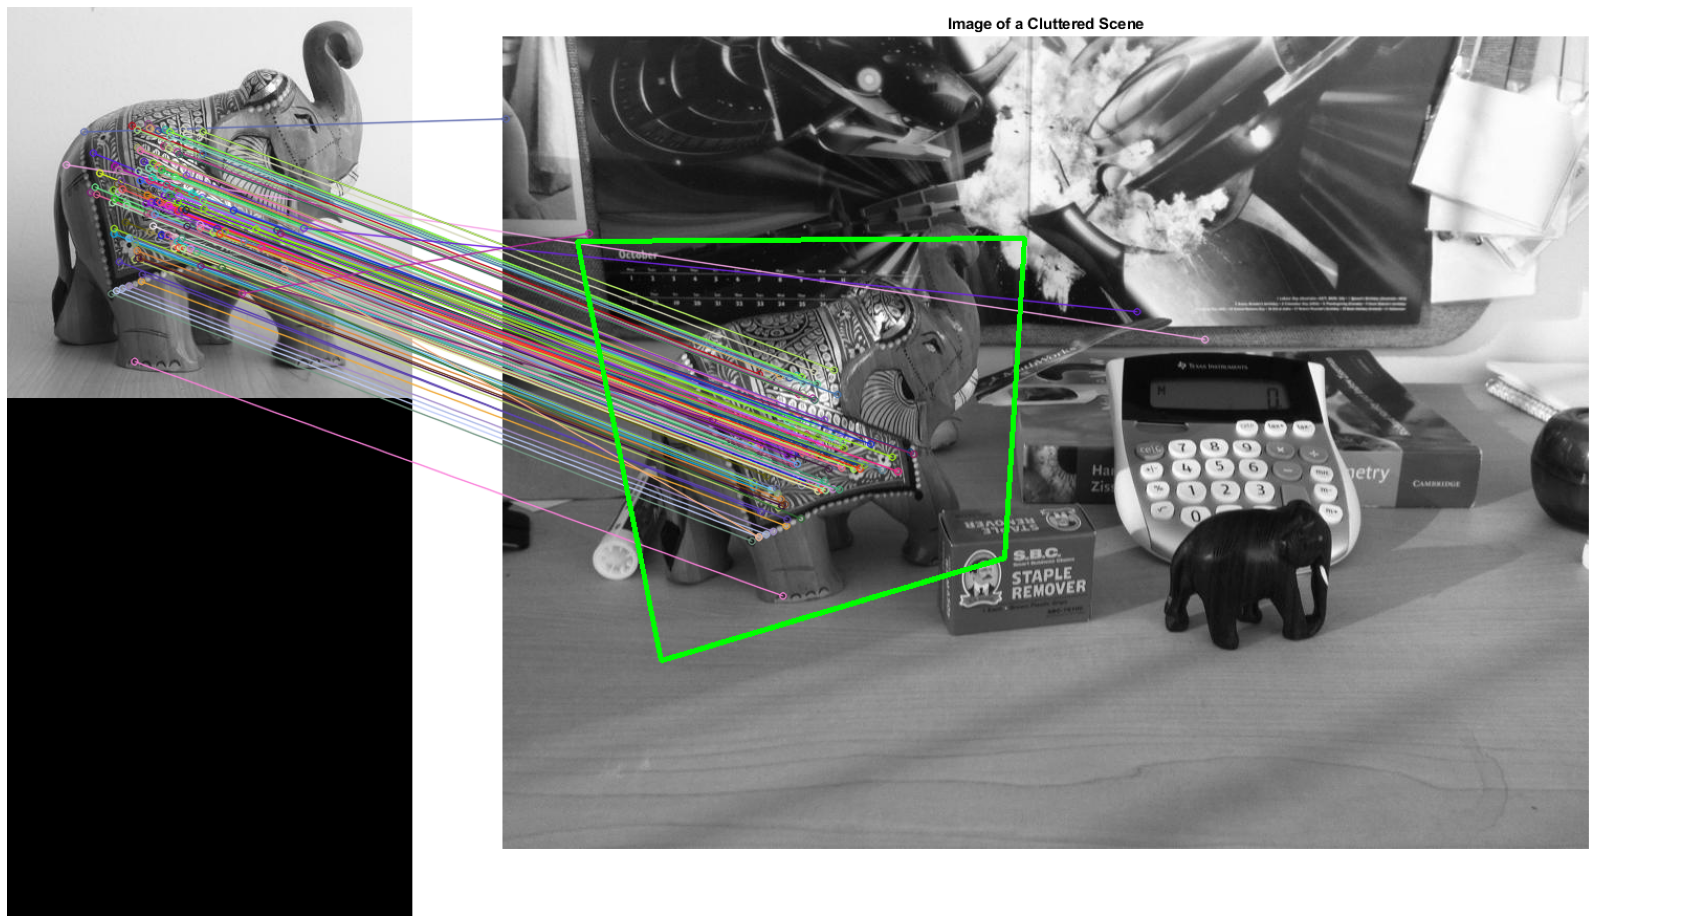

In [8]:
# Draw matches
img_matches = cv.drawMatches(object_img, kp1, scene_img, kp2,
                              good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches = cv.cvtColor(img_matches, cv.COLOR_BGR2RGB)
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

# Find the object in the scene
object_corners = np.float32([[0, 0], [object_img.shape[1], 0], [
                            object_img.shape[1], object_img.shape[0]], [0, object_img.shape[0]]])
scene_corners, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC)
scene_corners = cv.perspectiveTransform(
    object_corners.reshape(-1, 1, 2), scene_corners).reshape(-1, 2)

# Draw lines around the object in the scene
for i in range(4):
    pt1 = (int(scene_corners[i][0] + object_img.shape[1]),
           int(scene_corners[i][1]))
    pt2 = (int(scene_corners[(i+1) % 4][0] +
           object_img.shape[1]), int(scene_corners[(i+1) % 4][1]))
    cv.line(img_matches, pt1, pt2, (0, 255, 0), 4)


# Show detected matches
plt.figure(figsize=(30, 30))
plt.axis('off')
plt.imshow(img_matches, cmap='gray')
plt.show()
